In [23]:
import logging

logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import set_gpu_default_device

import cartopy.crs as ccrs
import pandas as pd

import numpy as np

In [24]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 10
extent = "north_america"
station_var_IDs = ["TAVG"]
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "mycache"
deepsensor_folder = "deepsensor_config/"
model_folder = "model/"
verbose_download = True

val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

In [25]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████| 120/120 [00:01<00:00, 86.52it/s]


1.41 GB loaded in 2.14 s


In [26]:
lowres_aux_raw_ds.sizes

Frozen({'lon': 120, 'lat': 72})

### All Acquisition Functions.
### 1. Sequential Greedy.
* 1.1 MeanStdDev
* 1.2 pNormStdDev
### 2. Oracle Sequential greedy Algorithm.
* 2.1 Oracle MAE.
* 2.2 Oracle RMSE.
* 2.3 Oracle Marginal NLL.
### Parallel Greedy Algorithm.
* 3.1 StdDev.
* 3.2 Expected Improvement.
### Heruistic Baseline Acquisition Function.
* 4.1 ContextDist.
* 4.2 Random.

### Total 9 major Acquisition functions.
* [MeanStdDev, pNormStdDev, Oracle MAE,Oracle RMSE,Oracle Marginal NLL, StdDev, Expected Improvement,ContextDist, Random]

In [27]:
crs = ccrs.PlateCarree()
test_date = pd.Timestamp("2019-06-25")

In [28]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

In [29]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [30]:
# Load model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [np.float32(0.00125), np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


In [31]:
X_c = 100

In [32]:
task = task_loader(test_date, (X_c, "all", "all"), seed_override=42)

In [33]:
# xarray object containing a mask to remove ocean points from the search and target points
mask_ds = land_mask_raw_ds

## Sequential Greedy Algo

* Sequentially loop over all search points, passing a query observation to the model at that point and computing the change in acquisition function.

In [12]:
from deepsensor.active_learning import GreedyAlgorithm

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=5,
    progress_bar=True,
)

### 1. MeanStdDev

100%|██████████| 965/965 [00:38<00:00, 24.91it/s]


Averaging acquisition function over dims for plotting: ['time']


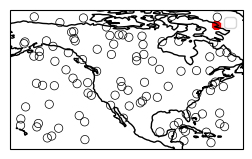

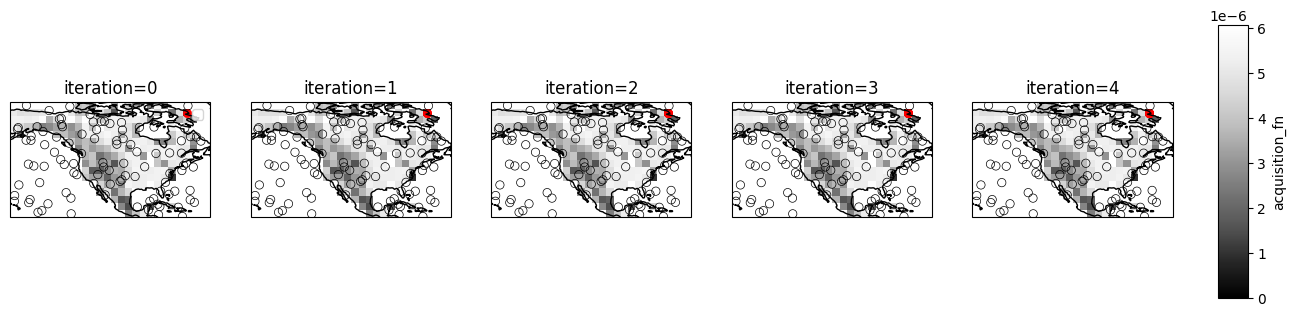

In [13]:
from deepsensor.active_learning.acquisition_fns import MeanStddev
acquisition_fn = MeanStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff= True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [ ]:
X_new_df

In [ ]:
acquisition_fn_ds.values

In [ ]:
acquisition_fn_ds[0].shape

In [ ]:
# Calculate mean and standard deviation across all points in acquisition_fn_ds
mean_value = acquisition_fn_ds.mean().item()  # Get as a scalar
stddev_value = acquisition_fn_ds.std().item()  # Get as a scalar

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

### 2. pNormStdDev

* Can be used to put greater emphasis on reducing the larger std deviation.

In [ ]:
from deepsensor.active_learning.acquisition_fns import pNormStddev
acquisition_fn = pNormStddev(model)

In [ ]:
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff = True)
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [ ]:
acquisition_fn_ds[0][0]

In [ ]:
acquisition_fn_ds.to_dataframe()

In [ ]:
mean_value = round(acquisition_fn_ds.mean().item(), 3)
stddev_value = round(acquisition_fn_ds.std().item(), 3)

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

### Oracle Sequential Greedy Algorithm.

In [ ]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=10, lon=10, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    query_infill=era5_ds,
    proposed_infill=era5_ds,
    N_new_context=5,
    task_loader=task_loader,
    verbose=True,
    progress_bar=True,
)

### 3. Oracle MAE.

In [ ]:
from deepsensor.active_learning.acquisition_fns import OracleMAE

acquisition_fn = OracleMAE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff = True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [ ]:
acquisition_fn_ds.to_dataframe()

In [ ]:
mean_value = acquisition_fn_ds.mean().item()
stddev_value = acquisition_fn_ds.std().item()

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

### 4. Oracle RMSE.


In [ ]:
from deepsensor.active_learning.acquisition_fns import OracleRMSE
acquisition_fn = OracleRMSE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff = True)

In [ ]:
fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [ ]:
mean_value = acquisition_fn_ds.mean().item()
stddev_value = acquisition_fn_ds.std().item()

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

### 5. oracle Marginal NLL

In [ ]:
from deepsensor.active_learning.acquisition_fns import OracleMarginalNLL
acquisition_fn = OracleMarginalNLL(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff = True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [ ]:
mean_value = acquisition_fn_ds.mean().item()
stddev_value = acquisition_fn_ds.std().item()

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

### Parallel Greedy Algorithm.
* Computed over all search points in parallel by running the model forwards once.

In [ ]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=5,
    progress_bar=True
)

In [ ]:
dates = val_dates
tasks = task_loader(dates, (X_c, "all", "all"), seed_override=42)

### 6. StdDev

In [ ]:
from deepsensor.active_learning.acquisition_fns import Stddev
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks)

fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")

In [ ]:
mean_value = acquisition_fn_ds.mean().item()
stddev_value = acquisition_fn_ds.std().item()

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

### 7. Expected Improvement 
* Can be used to get the most positive/ negative values in the data.
* average the acquisition function over tasks sampled from 52 equally spaced dates in 2020 to make the acquisition function more robust to the weather on a single day.

In [ ]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    proposed_infill=era5_ds,  # EI requires ground truth after proposal
    N_new_context=15,
    progress_bar=True,
    verbose=True,
)

In [ ]:
from deepsensor.active_learning.acquisition_fns import ExpectedImprovement

acquisition_fn = ExpectedImprovement(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, tasks)

In [ ]:
fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

In [ ]:
mean_value = acquisition_fn_ds.mean().item()
stddev_value = acquisition_fn_ds.std().item()

print("Mean of acquisition function dataset:", mean_value)
print("Standard deviation of acquisition function dataset:", stddev_value)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Generate some random off-grid data (irregular spacing)
np.random.seed(0)
n = 50
x = np.random.rand(n) * 10  # x coordinates (random, not evenly spaced)
y = np.random.rand(n) * 10  # y coordinates (random, not evenly spaced)
z = np.sin(x) + np.cos(y)  # Example function of x and y (values at random points)

# Plot the scattered data points
plt.scatter(x, y, c=z, cmap='coolwarm')
plt.colorbar()
plt.title('Off-grid Data (Scattered)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# Create a grid for interpolation
grid_x, grid_y = np.mgrid[0:10:100j, 0:10:100j]  # 100x100 grid

# Interpolate the off-grid data onto the grid
grid_z = interpolate.griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Plot the interpolated data as a contour plot
plt.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis')
plt.colorbar()
plt.title('Interpolated Off-grid Data Contour Plot')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple regular grid (on-grid data)
x = np.linspace(0, 10, 100)  # x coordinates (evenly spaced)
y = np.linspace(0, 10, 100)  # y coordinates (evenly spaced)
X, Y = np.meshgrid(x, y)  # Create a mesh grid from x and y
Z = np.sin(X) + np.cos(Y)  # Example function of X and Y

# Plot the data
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('On-grid Data Contour Plot')
plt.show()

### 8. ContexDist

In [ ]:
from deepsensor.active_learning.acquisition_fns import ContextDist

acquisition_fn = ContextDist(context_set_idx=0)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 55, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

### 9. Random.

In [ ]:
from deepsensor.active_learning.acquisition_fns import Random

acquisition_fn = Random()
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)